### 1) Portfolio - Generate dataset

In [1]:
import numpy as np
import pandas as pd
import sklearn.metrics
import datetime

from matplotlib import pyplot as plt

from qiskit_finance.data_providers import YahooDataProvider

plt.style.use('dark_background')


def get_risks(portfolios, sigma):
    
    risks = []
    
    for portfolio in portfolios:
        
        x_t = np.array(portfolio)
        x = np.array([portfolio]).T
        
        risk = x_t.dot(sigma).dot(x)
        
        risks.append(risk[0])
        
    return risks


def get_returns(portfolios, mu):
    
    returns = []
    
    for portfolio in portfolios:
        
        x = np.array([portfolio]).T
        
        return_value = mu.dot(x)   
        
        returns.append(return_value[0])
        
    return returns


def get_sharpe(portfolios, sigma, mu):
    
    risks = get_risks(portfolios, sigma)
    returns = get_returns(portfolios, mu)
    
    sharpe = np.array(returns) / np.array(risks)
    
    return sharpe


def samples_to_decimal(samples):

    sample_length = samples.shape[-1]

    indices = np.arange(sample_length)[::-1]

    terms = samples * 2 ** indices

    decimals = terms.sum(axis=1)

    return decimals

In [2]:
PORTFOLIOS_COUNT = 10 ** 4
ASSETS_COUNT = 8

START_DATE = datetime.datetime(2021, 9, 26)
END_DATE = datetime.datetime(2022, 9, 26)

sp_500 = pd.read_excel('simulated_prices/sp_500.xlsx')

symbols = sp_500['Symbol'].to_list()[:ASSETS_COUNT]

# symbols = ['NFLX', 'AAPL', 'META', 'GOOG', 'TSLA', 'AMZN', 'MSFT', 'NVDA']

portfolios = np.random.randint(0, 2, size=(PORTFOLIOS_COUNT * 2, ASSETS_COUNT))

unique_portfolios = np.unique(portfolios, axis=0)[:PORTFOLIOS_COUNT]

unique_portfolios

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 1]])

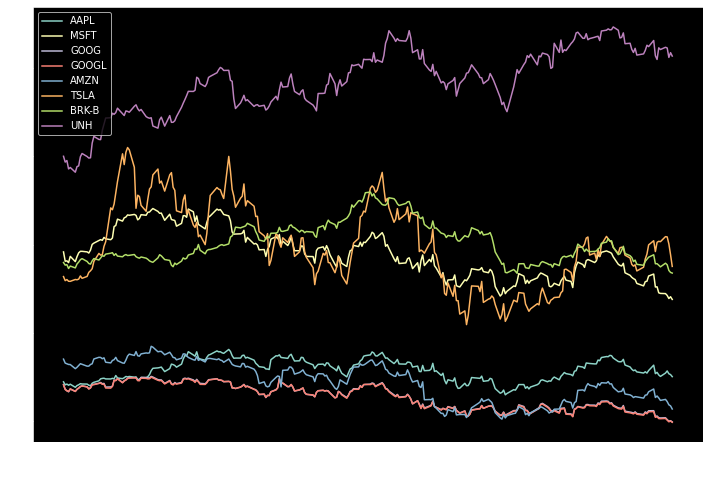

In [3]:
data = YahooDataProvider(tickers=symbols, start=START_DATE, end=END_DATE)
data.run()

plt.figure(figsize=(12, 8))

for i, symbol in enumerate(data._tickers):
    plt.plot(data._data[i], label=symbol)
    
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [4]:
# Statistical values

means = data.get_mean_vector()
rho = data.get_similarity_matrix()
cov = data.get_covariance_matrix()

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

# print("Means:\n", means)

# print("A time-series similarity measure:")
# plt.imshow(rho)
# plt.show()

# print("A covariance matrix:")
# plt.imshow(cov)
# plt.show()

# print("Sigma")
# plt.imshow(sigma, interpolation='nearest')
# plt.show()

# print("Mu:", mu)

In [5]:
# Sharpe Dataset

sharpe_dataset = pd.DataFrame(unique_portfolios)

sharpe_dataset['decimal'] = samples_to_decimal(unique_portfolios)

sharpe_dataset.sort_values('decimal', inplace=True)

sorted_portfolios = sharpe_dataset.to_numpy()[:, :-1]

sharpe_dataset['risk'] = get_risks(sorted_portfolios, sigma)
sharpe_dataset['return'] = get_returns(sorted_portfolios, mu)
sharpe_dataset['sharpe'] = sharpe_dataset['return'] / sharpe_dataset['risk']

sharpe_dataset.fillna(value=0, inplace=True)

sharpe_dataset

,0,1,2,3,4,5,6,7,decimal,risk,return,sharpe
0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
1,0,0,0,0,0,0,0,1,1,0.000230,0.001114,4.851260
2,0,0,0,0,0,0,1,0,2,0.000159,-0.000095,-0.600884
3,0,0,0,0,0,0,1,1,3,0.000584,0.001018,1.743169
4,0,0,0,0,0,1,0,0,4,0.001635,0.000988,0.604360
...,...,...,...,...,...,...,...,...,...,...,...,...
251,1,1,1,1,1,0,1,1,251,0.013737,-0.002823,-0.205516
252,1,1,1,1,1,1,0,0,252,0.016976,-0.002854,-0.168110
253,1,1,1,1,1,1,0,1,253,0.018953,-0.001740,-0.091806
254,1,1,1,1,1,1,1,0,254,0.019011,-0.002949,-0.155134


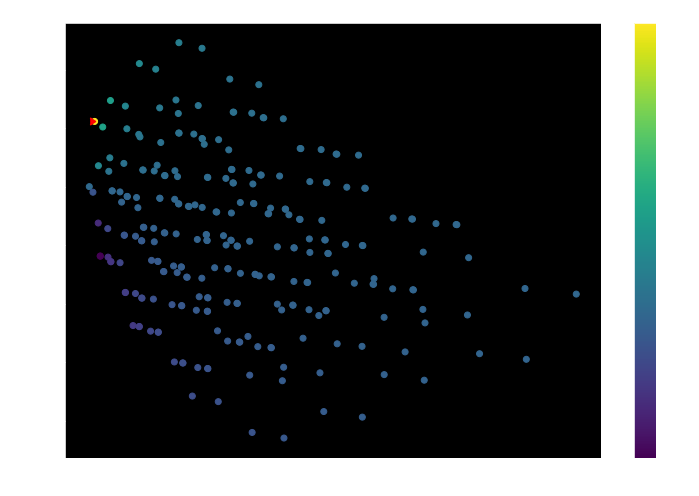

In [6]:
# Plot Sharpe Ratios

top_sharpe_index = sharpe_dataset.sharpe.idxmax()

top_sharpe_row = sharpe_dataset.iloc[top_sharpe_index]

top_return = top_sharpe_row['return']
top_risk = top_sharpe_row['risk']

plt.figure(figsize=(12, 8))

plt.title('Markowitz portfolio (Combinations of all portfolio selections)')
plt.xlabel('Volatility - standard deviation')
plt.ylabel('Return')

plt.scatter(sharpe_dataset.risk, sharpe_dataset['return'], c=sharpe_dataset.sharpe, cmap='viridis')
plt.scatter(top_risk, top_return, c='red', s=50, marker=5)  
plt.colorbar(label='Sharpe Ratio')

plt.show()

In [7]:
# # Save Dataset to file

# sharpe_dataset.to_csv('simulated_prices/sharpe_29.csv', index=False)

In [8]:
# sharpe_dataset.sort_values('sharpe', ascending=False)

### 2) Portfolio - FM

In [9]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import sklearn.metrics

import time
import tqdm
import torch

from torch.utils.data import DataLoader

%run models/models.ipynb

plt.style.use('dark_background')

In [10]:
class PortfolioDataset(torch.utils.data.Dataset):

    def __init__(self, dataset_path):        
        
        # Data
        
        self.data = pd.read_csv(dataset_path)
        
        data = self.data.to_numpy()
                        
        self.fields = data[:, :-4].astype(int)
        self.targets = data[:, -1]
        
        self.field_dimensions = np.max(self.fields, axis=0).astype(int) + 1
        
        self.field_dimensions[self.field_dimensions < 2] = 2
        
        
    def __len__(self):
        
        return self.fields.shape[0]
    

    def __getitem__(self, index):
        
        fields = self.fields[index]
        target = self.targets[index].squeeze()
        
        return fields, target
    
    def plot(self):

        top_sharpe_index = self.data.sharpe.idxmax()

        top_sharpe_row = self.data.iloc[top_sharpe_index]

        top_return = top_sharpe_row['return']
        top_risk = top_sharpe_row['risk']

        plt.figure(figsize=(12, 8))

        plt.title('Markowitz portfolio (Combinations of all portfolio selections)')
        plt.xlabel('Volatility - standard deviation')
        plt.ylabel('Return')

        plt.scatter(self.data.risk, self.data['return'], c=self.data.sharpe, cmap='viridis')
        plt.scatter(top_risk, top_return, c='red', s=50, marker=5)  
        plt.colorbar(label='Sharpe Ratio')

        plt.show()

In [11]:
class SequentialValueSampler(torch.utils.data.Sampler):

    def __init__(self, values):
        self.values = values

    def __iter__(self):
        return iter(self.values)

    def __len__(self):
        return len(self.values)


class Splitter:
    
    def __init__(self, dataset, shuffle=True, 
                 train_rate=0.8, valid_rate=0.1, 
                 batch_size=2048, dataloader_workers_count=8):
        
        self.dataset = dataset
                    
        dataset_length = len(dataset)

        train_length = int(dataset_length * train_rate)
        valid_length = int(dataset_length * valid_rate)

        test_length = dataset_length - train_length - valid_length
        
        self.lengths = (train_length, valid_length, test_length)

        dataset_indices = np.arange(dataset_length, dtype=int)
        
        if shuffle:        
            np.random.shuffle(dataset_indices)
        
        index_ranges = np.split(dataset_indices, (train_length,
                                                  train_length + valid_length))     
            
        train_sampler, valid_sampler, test_sampler = map(SequentialValueSampler, index_ranges)

        self.train_data_loader = DataLoader(dataset,
                                            batch_size=batch_size,
                                            sampler=train_sampler,
                                            num_workers=dataloader_workers_count)
        
        self.valid_data_loader = DataLoader(dataset,                                  
                                            batch_size=batch_size,
                                            sampler=valid_sampler,
                                            num_workers=dataloader_workers_count)
        
        self.test_data_loader = DataLoader(dataset,
                                           batch_size=batch_size,
                                           sampler=test_sampler,
                                           num_workers=dataloader_workers_count)   

In [12]:
class Trainer:

    def __init__(self, splitter,
                 learning_rate=0.001, weight_decay=1e-6,
                 embedding_dimensions=16,
                 model=None, criterion=None, metric=None, optimizer=None,
                 device='cpu', batch_logging_interval=100):

        %run models/models.ipynb 
        
        criterion = criterion or torch.nn.MSELoss()   

        metric = metric or sklearn.metrics.r2_score
        
        field_dimensions = splitter.dataset.field_dimensions
        
        model = model or CustomFactorizationMachine(field_dimensions, 
                                                    embedding_dimensions=embedding_dimensions)

        optimizer = torch.optim.Adam(params=model.parameters(), 
                                     lr=learning_rate, 
                                     weight_decay=weight_decay)
        
        self.device = torch.device(device)
        
        self.model = model.to(device)
        self.criterion = criterion
        self.metric = metric
        self.optimizer = optimizer
        self.splitter = splitter
        
        self.batch_logging_interval = batch_logging_interval
        
        self.train_data_loader = self.splitter.train_data_loader
        self.valid_data_loader = self.splitter.valid_data_loader
        self.test_data_loader = self.splitter.test_data_loader
        
        self.epoch_scores = []
        
        # TODO: EarlyStopper
    
    
    def fit(self, epochs=10):
        
        epoch_offset = len(self.epoch_scores)
        
        batches_count = epochs * len(self.splitter.train_data_loader)       
        
        fit_batch_tracker = tqdm.trange(
            batches_count,
            unit=' batches',
            ncols=110,
            mininterval=1,
        ) 
        
        for epoch in range(epochs):
            
            current_epoch = epoch_offset + epoch + 1
            max_epochs = epoch_offset + epochs

            fit_batch_tracker.set_description(f"Epoch: {current_epoch}/{max_epochs}")     
            
            self.train(fit_batch_tracker)
            
            epoch_score, _ = self.test(self.valid_data_loader)
            
            self.epoch_scores.append(epoch_score)
            
            fit_batch_tracker.set_postfix(r2=f"{epoch_score:.02f}")
            
        total_score, total_predictions = self.test(self.test_data_loader)
        
        print(f"\nTest {self.metric.__name__}: {total_score:.05f}")
    
    
    def train(self, fit_batch_tracker):

        self.model.train()

        interval_loss = 0

        for batch, (fields, target) in enumerate(self.splitter.train_data_loader):
            
            predictions = self.model(fields)
            
            loss = self.criterion(predictions, target.float())
            
            self.model.zero_grad()

            loss.backward()

            self.optimizer.step()

            interval_loss += loss.item()

            if not (batch + 1) % self.batch_logging_interval:

                average_loss = interval_loss / self.batch_logging_interval

                # fit_batch_tracker.set_postfix(loss=f"{average_loss:1.05f}")
                
                fit_batch_tracker.update(self.batch_logging_interval)
                
                interval_loss = 0
                
                
    def test(self, data_loader):
        
        self.model.eval()
    
        targets = []
        predictions = []

        with torch.no_grad():

            for fields, target in data_loader:

                prediction = self.model(fields)

                targets.extend(target.tolist())
                predictions.extend(prediction.tolist())

        score = self.metric(targets, predictions)
        
        return score, predictions
    

    def predict(self, indices):   
        
        encoded_fields = self.splitter.dataset.fields[indices]
        targets = self.splitter.dataset.targets[indices]

        self.model.eval()

        with torch.no_grad():

            predictions = self.model(torch.tensor(encoded_fields))
        
        return targets, predictions

dataset.field_dimensions: [2 2 2 2 2 2 2 2]


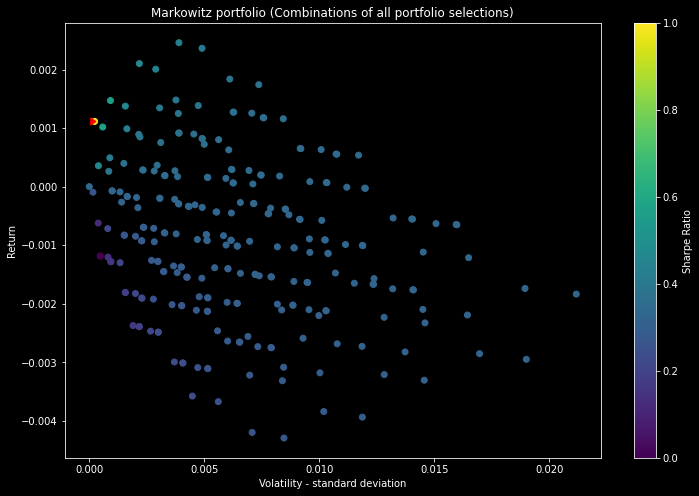

In [18]:
DATASET_PATH = 'simulated_prices/sharpe_29.csv'

dataset = PortfolioDataset(DATASET_PATH)

print("dataset.field_dimensions:", dataset.field_dimensions)
# print(dataset.data.head())
dataset.plot()

In [19]:
splitter = Splitter(dataset, batch_size=100, dataloader_workers_count=8)

trainer = Trainer(splitter=splitter, embedding_dimensions=16)

print("Dataset field:", dataset.fields.shape)
print("Dataset targets:", dataset.targets.shape) 
# print("dataset.field_dimensions:", dataset.field_dimensions)
print("Splitter lengths:", splitter.lengths) 

Dataset field: (256, 8)
Dataset targets: (256,)
Splitter lengths: (204, 25, 27)


In [22]:
trainer.fit(epochs=100)

Epoch: 200/200:   0%|                                                  | 0/300 [00:14<?, ? batches/s, r2=0.78]


Test r2_score: 0.29923


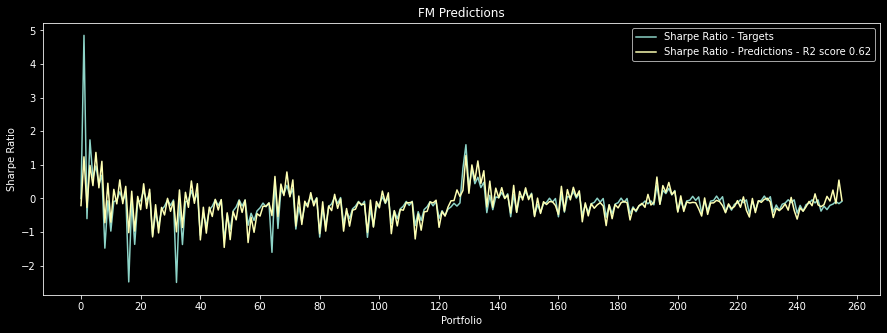

In [23]:
# Predict

INDEX_STEP = 1

indices = np.arange(0, len(dataset), INDEX_STEP)

targets, predictions = trainer.predict(indices)

r2_score = sklearn.metrics.r2_score(targets, predictions)

# Plot

plt.figure(figsize=(15, 5))

plt.plot(targets, label=f"Sharpe Ratio - Targets")
plt.plot(predictions, label=f"Sharpe Ratio - Predictions - R2 score {r2_score:.02f}")

plt.locator_params(axis='x', nbins=20)

plt.title("FM Predictions")
plt.xlabel("Portfolio")
plt.ylabel("Sharpe Ratio")
plt.legend()

plt.show()

### 3) Portfolio - QUBO

In [24]:
class PortfolioQubo:
    
    def __init__(self, trainer,
                 one_hot_scheme=None, maximize=True,
                 penalty_value=1000):
        
        default_one_hot_scheme = {0: (0, 1), 1: (1, 0)}
        
        self.one_hot_scheme = one_hot_scheme or default_one_hot_scheme 
        
        self.one_hot_decoding_scheme = {value: key for key, value in 
                                        self.one_hot_scheme.items()}
        
        # dimod.ExactSolver
      
        self.trainer = trainer
        self.maximize = maximize
        self.penalty_value = penalty_value
        
        
        # Load weights
        
        state_dict = trainer.model.state_dict()

        factorization_matrix = state_dict['embedding.embedding.weight'].numpy().squeeze()
        
        
        # TODO: remove swapped factorization matrix
        
        swapped_factorization_matrix = np.zeros_like(factorization_matrix)
        
        swapped_factorization_matrix[::2] = factorization_matrix[1::2]
        swapped_factorization_matrix[1::2] = factorization_matrix[::2]
        
                     
        self.factorization_matrix = swapped_factorization_matrix
        
        # print("self.factorization_matrix:", self.factorization_matrix, self.factorization_matrix.shape)
        
        self.one_hot_penalty = self.get_one_hot_penalty()
        
        self.qubo_coefficients = self.get_qubo_coefficients()
        
        # print(self.input_penalty)
        # print(self.one_hot_penalty)
        # print(self.qubo_coefficients)
        

    def get_one_hot_penalty(self):

        one_hot_pair_penalty = self.penalty_value * np.array([[-1,  2],
                                                              [ 2, -1]])
        
        bits_count = len(self.factorization_matrix) // 2

        one_hot_penalty_diagonal = np.ones(bits_count)

        one_hot_penalty_matrix = np.diag(one_hot_penalty_diagonal)

        one_hot_penalty = np.kron(one_hot_penalty_matrix, one_hot_pair_penalty)


        # print("one_hot_pair_penalty:\n", one_hot_pair_penalty)
        # print("one_hot_penalty_diagonal:\n", one_hot_penalty_diagonal)
        # print("one_hot_penalty_matrix:\n", one_hot_penalty_matrix)
        # print("one_hot_penalty:\n", one_hot_penalty, one_hot_penalty.shape)
        
        return one_hot_penalty
    
    
    def get_qubo_coefficients(self):
        
        coupling_matrix = self.factorization_matrix @ self.factorization_matrix.T
        
        np.fill_diagonal(coupling_matrix, 0)

        if self.maximize:

            coupling_matrix = -coupling_matrix

        penalized_coupling_matrix = coupling_matrix + self.one_hot_penalty

        qubo_coefficients = self.get_coupling_coefficients(penalized_coupling_matrix)
        
        self.coupling_matrix = coupling_matrix
        
        self.penalized_coupling_matrix = penalized_coupling_matrix

#         print("self.factorization_matrix:\n", self.factorization_matrix.shape)
#         print("coupling_matrix:\n", coupling_matrix.shape)
#         print("penalized_coupling_matrix part:\n", penalized_coupling_matrix[-3:, -3:])
#         print("qubo_coefficients part:\n", qubo_coefficients.__repr__()[-60:])
        
        return qubo_coefficients


    def bits_to_one_hot(self, bits):
        
        one_hot_bits = [self.one_hot_scheme[bit] for bit in bits]

        one_hot_array = np.array(one_hot_bits, dtype='i1').ravel()

        return one_hot_array
    
    
    def one_hot_to_bits(self, one_hot):    

        bits = []

        for one_hot_pair in one_hot.reshape(-1, 2):

            bit = self.one_hot_decoding_scheme[tuple(one_hot_pair)]

            bits.append(bit)

        bits_array = np.array(bits, dtype='i1')    

        return bits_array
    
    
    def bit_to_spin(self, binary):    
        return binary * 2 - 1

    def spin_to_bit(self, spin):    
        return (spin + 1) // 2
    
    
    def get_coupling_coefficients(self, coupling_matrix):

        coupling_coefficients = dict()

        for row_index, row in enumerate(coupling_matrix):

            for column_index, cell in enumerate(row[row_index:], row_index):

                coupling_coefficients[row_index, column_index] = cell

        return coupling_coefficients
    
    
    def is_correct_one_hot(self, record):

        sample = record.sample

        fields_spins = np.array(list(sample.values()))

        fields_one_hot = self.spin_to_bit(fields_spins)

        for one_hot_pair in fields_one_hot.reshape(-1, 2):

            one_hot_tuple = tuple(one_hot_pair)

            if one_hot_tuple not in self.one_hot_scheme.values():            

                return False

        return True

In [25]:
PENALTY_VALUE = 1000

MAXIMIZE = True

qubo = PortfolioQubo(trainer=trainer,
                     penalty_value=PENALTY_VALUE,
                     maximize=MAXIMIZE)

### 4) Portfolio - QUBO Energies

In [26]:
import dimod

INDEX_STEP = 1

indices = np.arange(0, len(dataset), INDEX_STEP)

bqm = dimod.BinaryQuadraticModel.from_qubo(qubo.qubo_coefficients)

quadratic = bqm.quadratic
linear = bqm.linear
offset = bqm.offset

energies = []
bqm_energies = []


for row_bits in dataset.fields[indices]:
    
    one_hot_row = qubo.bits_to_one_hot(row_bits)

    sample = dict(enumerate(one_hot_row))

    energy = dimod.utilities.qubo_energy(sample=sample, Q=qubo.qubo_coefficients)
        
    bqm_energy = dimod.utilities.ising_energy(sample=sample, J=quadratic, h=linear, offset=offset)
    
    energies.append(energy)
    bqm_energies.append(bqm_energy)

In [27]:
# Predict

targets, predictions = trainer.predict(indices)

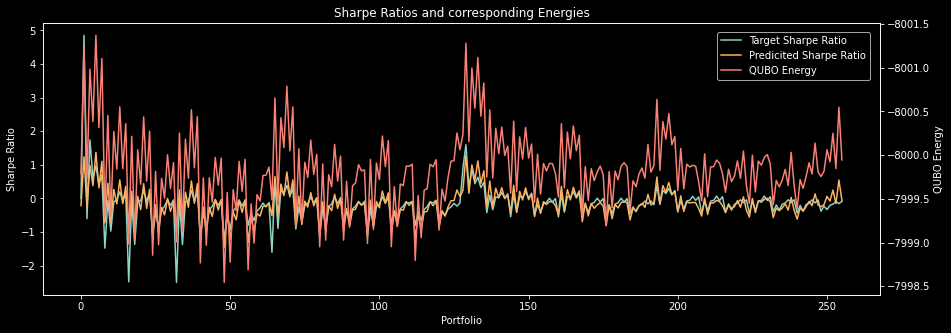

In [28]:
# General Plot

figure, data_ax = plt.subplots(figsize=(15, 5))
energy_ax = data_ax.twinx()

data_ax.plot(indices, targets, label="Target Sharpe Ratio")
data_ax.plot(indices, predictions, label="Predicited Sharpe Ratio", color='#fdb462')
energy_ax.plot(indices, energies, label="QUBO Energy", color='#fa8174')
# energy_ax.plot(indices, bqm_energies, label="BQM Energy", color='r')

energy_ax.invert_yaxis()

plt.title('Sharpe Ratios and corresponding Energies')
data_ax.set_xlabel("Portfolio")
data_ax.set_ylabel("Sharpe Ratio")
energy_ax.set_xlabel("Portfolio")
energy_ax.set_ylabel("QUBO Energy")

figure.legend(bbox_to_anchor=(0.895, 0.87))

plt.show()

In [29]:
# PART = 10

# plt.plot(indices[:PART], targets[:PART], label="Target Sharpe Ratio")
# plt.xlabel("Portfolio")
# plt.ylabel("Sharpe Ratio")
# plt.legend()
# plt.show()

# plt.plot(indices[:PART], predictions[:PART], label="Predicited Sharpe Ratio", color='#fdb462')
# plt.xlabel("Portfolio")
# plt.ylabel("Sharpe Ratio")
# plt.legend()
# plt.show()

# plt.plot(indices[:PART], energies[:PART], label="QUBO Energy", color='#fa8174')
# plt.xlabel("energy")
# plt.ylabel("Sharpe Ratio")
# plt.legend()
# plt.show()

### 5) Portfolio - Run on Simulator

In [30]:
from neal.sampler import SimulatedAnnealingSampler

import dimod

dimod.serialization.format.set_printoptions(width=110, depth=10)


shots_count = 10000

sampler = SimulatedAnnealingSampler()

# new_bqm = dimod.BinaryQuadraticModel(bqm.linear,
#                                      bqm.quadratic,
#                                      bqm.offset,
#                                      vartype=dimod.BINARY)

# spin_bqm = new_bqm.change_vartype(dimod.SPIN, inplace=False)


sampling_results = sampler.sample_qubo(Q=qubo.qubo_coefficients, num_reads=shots_count)

# sampling_results = sampler.sample_qubo(Q=range_qubo_coefficients, num_reads=shots_count)

# sampling_results = sampler.sample_qubo(Q=excluded_qubo_coefficients, num_reads=shots_count)


# sampling_results = sampler.sample_ising(J=bqm.quadratic, h=bqm.linear, num_reads=shots_count)

# new_linear = {k[0]: v for k, v in qubo.qubo_coefficients.items() if k[0] == k[1]}

# sampling_results = sampler.sample_ising(J=qubo.qubo_coefficients, h=new_linear, num_reads=shots_count)

# sampling_results = sampler.sample(bqm=spin_bqm, num_reads=shots_count)

In [31]:
aggregated_results = sampling_results.aggregate()

filtered_results = aggregated_results.filter(pred=qubo.is_correct_one_hot)

print("sampling_results:", len(sampling_results))
print("aggregated_results:", len(aggregated_results))
print("filtered_results:", len(filtered_results))

# print("sampling_results:\n", sampling_results)
# print("aggregated_results:\n", aggregated_results)
# print("filtered_results:\n", filtered_results)

sampling_results: 10000
aggregated_results: 256
filtered_results: 256


In [32]:
# Decode

decoded_results = []

for sample in filtered_results.data():
    
    result = sample.sample
    
    one_hot_array = np.array(list(sample.sample.values()))
    portfolio = qubo.one_hot_to_bits(one_hot_array)
    decimal = sum(number * 2 ** position for position, number in enumerate(reversed(portfolio)))
    
    result['portfolio'] = portfolio
    result['decimal'] = decimal
    
    result['energy'] = sample.energy
    result['num_occurrences'] = sample.num_occurrences
    
    decoded_results.append(result)
    
decoded_results = pd.DataFrame(decoded_results)

filtered_columns = ['asset_price', 'energy', 'num_occurrences']

# pd.set_option('display.max_rows', 10)

print("maximize:\n", MAXIMIZE)
print("decoded_results:\n", decoded_results)

maximize:
 True
decoded_results:
      0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  \
0    0  1  0  1  0  1  0  1  0  1   1   0   0   1   1   0   
1    1  0  0  1  0  1  0  1  0  1   0   1   0   1   1   0   
2    0  1  0  1  0  1  0  1  0  1   0   1   0   1   1   0   
3    1  0  0  1  0  1  0  1  0  1   1   0   0   1   1   0   
4    0  1  0  1  0  1  0  1  0  1   1   0   1   0   1   0   
..  .. .. .. .. .. .. .. .. .. ..  ..  ..  ..  ..  ..  ..   
251  0  1  1  0  1  0  1  0  0  1   0   1   0   1   0   1   
252  0  1  0  1  1  0  1  0  0  1   0   1   1   0   0   1   
253  0  1  0  1  1  0  0  1  1  0   0   1   0   1   0   1   
254  0  1  0  1  1  0  1  0  1  0   0   1   0   1   0   1   
255  0  1  0  1  1  0  1  0  0  1   0   1   0   1   0   1   

                    portfolio  decimal       energy  num_occurrences  
0    [0, 0, 0, 0, 0, 1, 0, 1]        5 -8001.369799               37  
1    [1, 0, 0, 0, 0, 0, 0, 1]      129 -8001.278669               34  
2    [0, 0, 0, 0, 0,

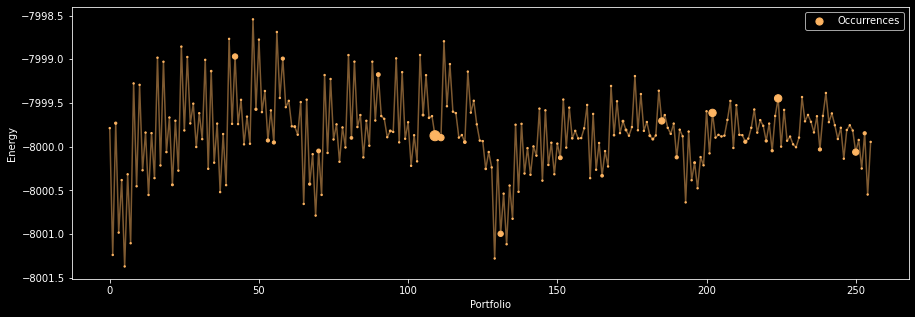

In [33]:
# Plot

results = decoded_results.sort_values('decimal')

portfolios = results['portfolio'].to_numpy()
decimals = results['decimal'].to_numpy()
energies = results['energy'].to_numpy()
sizes = results['num_occurrences'].to_numpy()
    
sizes = sizes - min(sizes)
sizes = sizes ** 10
sizes = sizes / (max(sizes) or 1) * 100 
sizes[sizes < 1] = 1


plt.plot(decimals, energies, color='#fdb462', alpha=0.5)

plt.scatter(decimals, energies,
            label=f"Occurrences",
            color='#fdb462',
            s=sizes + 1)

plt.xlabel("Portfolio")
plt.ylabel("Energy")
plt.legend()

# plt.gca().invert_yaxis()
plt.gcf().set_size_inches(15, 5)

plt.show()

### 6) Portfolio - Run on DWave device

In [34]:
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketDWaveSampler
from dwave.system.composites import EmbeddingComposite

from braket.tracking import Tracker

cost_tracker = Tracker().start()

COST_LIMIT = 1

In [35]:
# D-Wave 2000Q device
device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6")

# # D-Wave Advantage device
# device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/Advantage_system4")

print(f"device.name:", device.name)
print(f"device.properties.provider.topology:", device.properties.provider.topology)
print(f"device.properties.provider.qubitCount:", device.properties.provider.qubitCount)
print(f"len(device.properties.provider.couplers):", len(device.properties.provider.couplers))
print(f"device.properties.service.shotsRange:", device.properties.service.shotsRange)
print(f"device.properties.service.deviceLocation:", device.properties.service.deviceLocation)

device.name: DW_2000Q_6
device.properties.provider.topology: {'type': 'chimera', 'shape': [16, 16, 4]}
device.properties.provider.qubitCount: 2048
len(device.properties.provider.couplers): 5974
device.properties.service.shotsRange: (1, 10000)
device.properties.service.deviceLocation: British Columbia, Canada


In [36]:
qubo.coupling_matrix.shape

(16, 16)

In [37]:
dwave_2000q_sampler = BraketDWaveSampler(device_arn='arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')
embedded_sampler = EmbeddingComposite(dwave_2000q_sampler)

In [38]:
num_reads = 1000

# if cost_tracker.qpu_tasks_cost() < COST_LIMIT:

#     sampling_results = embedded_sampler.sample_qubo(Q=qubo.qubo_coefficients, num_reads=num_reads)

In [39]:
print("quantum_tasks_statistics:", cost_tracker.quantum_tasks_statistics())
print("qpu_tasks_cost:", cost_tracker.qpu_tasks_cost())
print("simulator_tasks_cost:", cost_tracker.simulator_tasks_cost())

quantum_tasks_statistics: {}
qpu_tasks_cost: 0
simulator_tasks_cost: 0


In [40]:
# # Save results

# RESULTS_FILENAME = 'results/2000q_16_qubits.npy'

# np.save(RESULTS_FILENAME, sampling_results)

In [41]:
# Load results

RESULTS_FILENAME = 'results/2000q_16_qubits.npy'

sampling_results = np.load(RESULTS_FILENAME, allow_pickle=True).item()

In [42]:
aggregated_results = sampling_results.aggregate()

filtered_results = aggregated_results.filter(pred=qubo.is_correct_one_hot)

print("sampling_results:", len(sampling_results))
print("aggregated_results:", len(aggregated_results))
print("filtered_results:", len(filtered_results))

# print("sampling_results:\n", sampling_results)
# print("aggregated_results:\n", aggregated_results)
# print("filtered_results:\n", filtered_results)

sampling_results: 271
aggregated_results: 268
filtered_results: 229


In [43]:
# Decode

decoded_results = []

for sample in filtered_results.data():
    
    result = sample.sample
    
    one_hot_array = np.array(list(sample.sample.values()))
    portfolio = qubo.one_hot_to_bits(one_hot_array)
    decimal = sum(number * 2 ** position for position, number in enumerate(reversed(portfolio)))
    
    result['portfolio'] = portfolio
    result['decimal'] = decimal
    
    result['energy'] = sample.energy
    result['num_occurrences'] = sample.num_occurrences
    
    decoded_results.append(result)
    
decoded_results = pd.DataFrame(decoded_results)

filtered_columns = ['asset_price', 'energy', 'num_occurrences']

# pd.set_option('display.max_rows', 10)

print("maximize:\n", MAXIMIZE)
print("decoded_results:\n", decoded_results)

maximize:
 True
decoded_results:
      0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  \
0    1  0  0  1  0  1  0  1  0  1   0   1   0   1   1   0   
1    1  0  0  1  0  1  0  1  0  1   1   0   0   1   1   0   
2    1  0  0  1  0  1  0  1  0  1   0   1   1   0   1   0   
3    0  1  0  1  0  1  0  1  0  1   0   1   0   1   1   0   
4    0  1  0  1  0  1  0  1  0  1   1   0   0   1   1   0   
..  .. .. .. .. .. .. .. .. .. ..  ..  ..  ..  ..  ..  ..   
224  0  1  1  0  0  1  1  0  1  0   0   1   0   1   0   1   
225  0  1  0  1  1  0  0  1  1  0   0   1   1   0   0   1   
226  0  1  0  1  1  0  1  0  0  1   0   1   0   1   0   1   
227  0  1  0  1  0  1  1  0  1  0   0   1   0   1   0   1   
228  0  1  0  1  1  0  0  1  1  0   0   1   0   1   0   1   

                    portfolio  decimal       energy  num_occurrences  
0    [1, 0, 0, 0, 0, 0, 0, 1]      129 -8001.237037                3  
1    [1, 0, 0, 0, 0, 1, 0, 1]      133 -8001.080120                2  
2    [1, 0, 0, 0, 0,

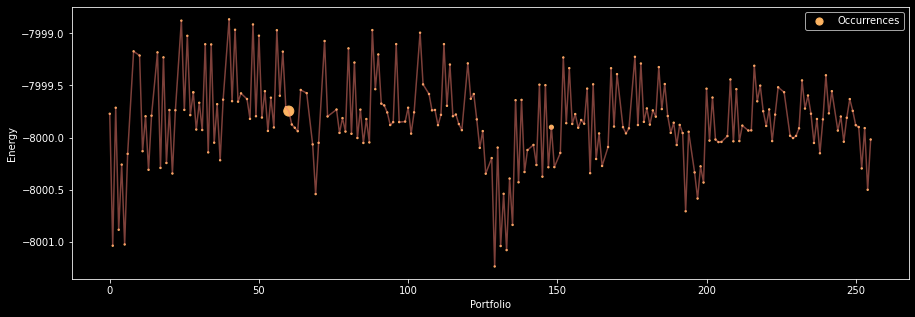

In [45]:
# Plot

results = decoded_results.sort_values('decimal')

portfolios = results['portfolio'].to_numpy()
decimals = results['decimal'].to_numpy()
energies = results['energy'].to_numpy()
sizes = results['num_occurrences'].to_numpy()
    
sizes = sizes - min(sizes)
sizes = sizes ** 10
sizes = sizes / (max(sizes) or 1) * 100 
sizes[sizes < 1] = 1


plt.plot(decimals, energies, color='#fa8174', alpha=0.5)

plt.scatter(decimals, energies,
            label=f"Occurrences",
            color='#fdb462',
            s=sizes + 1)

plt.xlabel("Portfolio")
plt.ylabel("Energy")
plt.legend()

# plt.gca().invert_yaxis()
plt.gcf().set_size_inches(15, 5)

plt.show()